In [1]:
%matplotlib inline

In [2]:
import matplotlib.pylab as plt
import matplotlib.dates as mdates
import matplotlib.cm as cm
import numpy as np
import pandas as pd

In [6]:
data = pd.read_csv("./examples/TB3MS.csv", parse_dates=["DATE"])
r = np.loadtxt("./treasury_bill_output_r.txt")
change_points = np.loadtxt("./treasury_bill_output_change_points.txt").astype(np.uint)

/home/schmidmt/.local/lib64/python3.6/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, 'MAP')

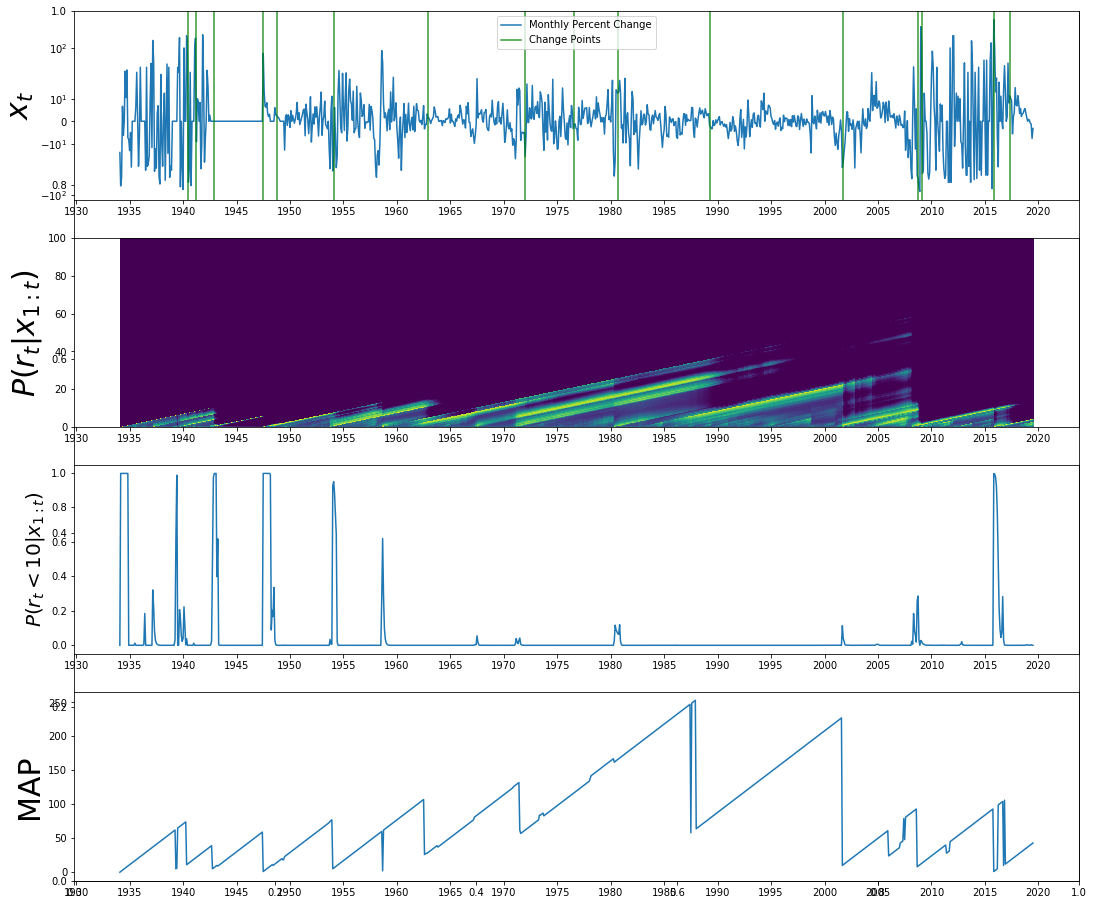

In [7]:
fig, ax = plt.subplots(figsize=[18, 16])

ax = fig.add_subplot(4, 1, 1)
ax.plot("DATE", "TB3MS_PCH", data=data, label="Monthly Percent Change")
ax.xaxis.set_major_locator(mdates.YearLocator(5))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))

ax.set_yscale('symlog', linthreshy=20)
ax.set_ylabel("$x_t$", fontsize=30)
for change_point in change_points:
    line = ax.axvline(data.DATE.iloc[change_point], color="green", alpha=0.8)
line.set_label("Change Points")
ax.legend()
 
ax = fig.add_subplot(4, 1, 2, sharex=ax)
x_lims = mdates.date2num([data.DATE.min(), data.DATE.max()])
ax.imshow(
    -np.log(np.rot90(r + 1E-10, 1)),
    cmap=cm.viridis_r,
    extent = [x_lims[0], x_lims[1], 0, 100],
    aspect="auto",
)
ax.set_ylabel("$P(r_t|x_{1:t})$", fontsize=30)

ax = fig.add_subplot(4, 1, 3, sharex=ax)
w = 10
ax.plot(list(map(mdates.date2num, data.DATE)), np.sum(r[:, 1:w], axis=1))
ax.set_ylabel(f"$P(r_t < {w}|x_{{1:t}})$", fontsize=20)

ax = fig.add_subplot(4, 1, 4, sharex=ax)
ax.plot(list(map(mdates.date2num, data.DATE)), np.argmax(r, axis=1))
ax.set_ylabel("MAP", fontsize=30)

/home/schmidmt/.local/lib64/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


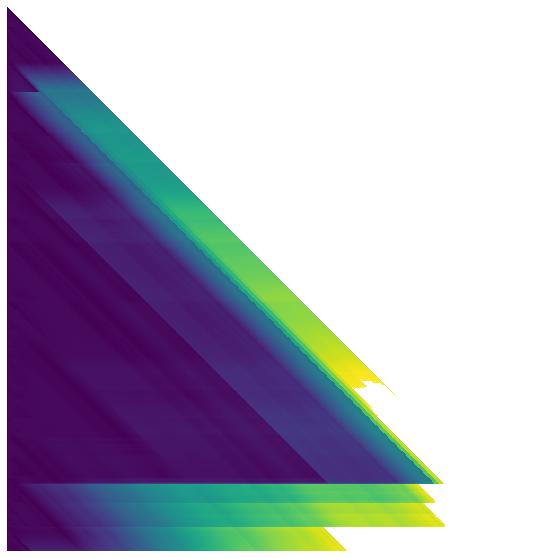

In [22]:
fig, ax = plt.subplots(figsize=(10, 10))
plt.imshow(np.log(r), cmap=cm.viridis_r)
plt.axis('off')
fig.savefig("/tmp/cpd.svg", bbox_inches='tight')